In [2]:
import json
from itertools import product
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter

import wandb

rc_fonts = {
    "text.usetex": True,
    # "text.latex.preamble": "\n".join(
    #     [
    #         r"\usepackage{libertine}",
    #         r"\usepackage[libertine]{newtxmath}",
    #         r"\usepackage{inconsolata}",
    #     ]
    # ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


## Run data

In [3]:
api = wandb.Api()

RUN_SCALE = "tiny"

runs = [
    api.run("pico-lm/pico-decoder/lne20rc1"),  # pico decoder tiny
    api.run("pico-lm/pico-relora/6vhmv4aj"),  # pico relora tiny
    api.run("pico-lm/pico-decoder/kzcalg17"),  # small
    api.run("pico-lm/pico-relora/5urfvs2j"),
]

dfs: list[pd.DataFrame] = []


def _get_data(scale):
    for i in range(0, 20_001, 1_000):
        path = Path(f"blimp_results_{scale}/step_{i}.json")
        with path.open() as f:
            data = json.load(f)
        if "blimp" in data:
            data = data["blimp"]
        yield (i, data["accuracy"])


for ridx, run in enumerate(runs):
    df = pd.DataFrame(run.scan_history())
    is_decoder = ridx % 2 == 0
    df["Model"] = rf"\texttt{{pico-{'decoder' if is_decoder else 'relora'}}}"
    scale = "tiny" if ridx < 2 else "small"
    df["Scale"] = scale

    if is_decoder:
        df_to_merge = pd.DataFrame(_get_data(scale), columns=["trainer/global_step", "eval/blimp"])
        df = pd.merge(df, df_to_merge, how="left", on="trainer/global_step")

    dfs.append(df)

In [4]:
runtime_data = pd.concat(dfs, ignore_index=True)


runtime_data.rename(
    columns={"eval/paloma": "PPL", "train/loss": "Loss", "eval/blimp": "BLiMP"}, inplace=True
)

runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^blimp/").columns)
runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^relora/").columns)


runtime_data = runtime_data[runtime_data["trainer/global_step"] <= 20_001]

In [5]:
f_run_data = runtime_data[
    runtime_data["PPL"].notna() | runtime_data["Loss"].notna() | runtime_data["BLiMP"].notna()
]

loss_data = (
    f_run_data[["trainer/global_step", "Loss", "Model", "Scale"]].dropna().rename(columns={"Loss": "Value"})
)
loss_data["Metric"] = "Loss"

ppl_data = (
    f_run_data[["trainer/global_step", "PPL", "Model", "Scale"]].dropna().rename(columns={"PPL": "Value"})
)
ppl_data["Metric"] = "PPL"

blimp_data = (
    f_run_data[["trainer/global_step", "BLiMP", "Model", "Scale"]]
    .dropna()
    .rename(columns={"BLiMP": "Value"})
)
blimp_data["Metric"] = "BLiMP"

# Concatenate the dataframes
combined_data = pd.concat([loss_data, ppl_data, blimp_data], ignore_index=True)
# combined_data = combined_data[combined_data["trainer/global_step"] <= 20_000]

## Cond num data

In [6]:
tiny_lora = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora = api.run("pico-lm/pico-relora/a8nvp3mi")
tiny_base = api.run("pico-lm/pico-relora/rpfgrgc4")
small_base = api.run("pico-lm/pico-relora/vmyjbapv")

In [7]:
data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_71293/3679100403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_71293/3679100403.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [8]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [9]:
STEP_MOD = 2_000

In [10]:
MODS = ("swiglu.w_2", "attention.v_proj", "attention.o_proj")

In [11]:
def _get_cn_data():
    for mod_idx, mod in enumerate(MODS):
        for t in data:
            for s in data[t]:
                metr_str = (
                    "condition_number_val/_forward_module.module.layers.{}"
                    + f".{mod}{'.lora' if t == 'lora' else ''}."
                    + ("weights" if t == "lora" else "gradients")
                )
                val = get_across_ranges(
                    data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
                )
                for ckp_id, ckp in enumerate(val):
                    for lay_id, layer_val in enumerate(ckp):
                        yield (
                            [r"SwiGLU $W_2$", r"Attn Value Projection", r"Attn Output Projection"][mod_idx],
                            rf"\texttt{{pico-{'decoder' if t == 'base' else 'relora'}}}",
                            s,
                            int(ckp_id * 2),
                            lay_id,
                            layer_val,
                        )


cn_data = pd.DataFrame(
    _get_cn_data(),
    columns=["Component", "Model", "Scale", "Step", "Layer", "CondNum"],
)

In [12]:
def compute_ci(df):
    mean = df["CondNum"].mean()
    sem = stats.sem(df["CondNum"], nan_policy="propagate")
    ci = sem * stats.t.ppf(0.975, len(df["CondNum"]) - 1)
    return pd.Series({"mean": mean, "ci": ci})


agg_cn_data = cn_data.groupby(["Component", "Model", "Scale", "Step"]).apply(compute_ci).reset_index()

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_71293/3170766391.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_cn_data = cn_data.groupby(["Component", "Model", "Scale", "Step"]).apply(compute_ci).reset_index()


## Actually plotting

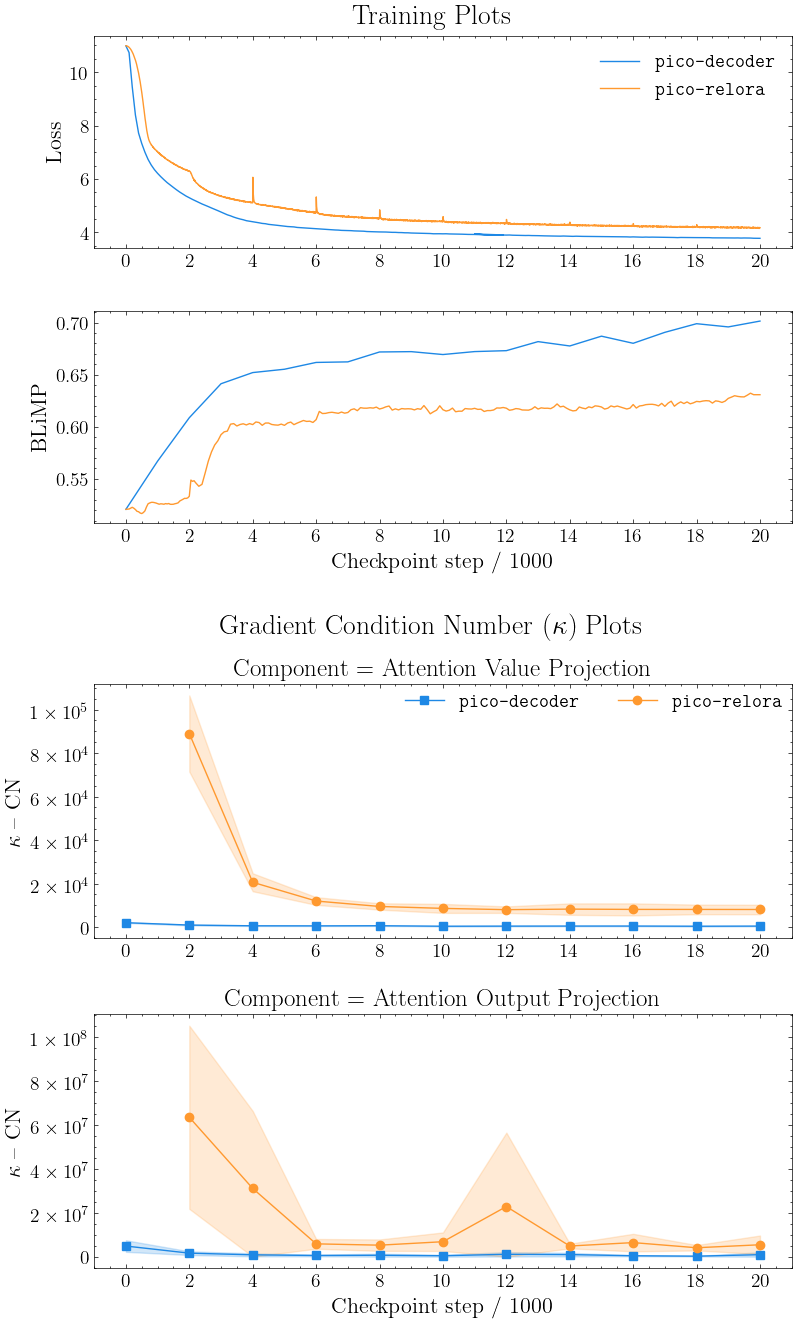

In [44]:
# ---- Setup shared style ----
plt.style.use(["science"])
plt.rcParams.update(
    {
        "font.size": 16,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 20,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    }
)


def format_scientific_0dp(number, _):
    if number == 0:
        return "0"
    exponent = int(f"{number:e}".split("e")[1])
    mantissa = round(number / (10**exponent))
    return rf"${mantissa} \times 10^{exponent}$"


# ---- Define color palette ----
colors = ["#1E88E5", "#FF992F"]
model_list = sorted(list(set(combined_data["Model"].unique()) | set(cn_data["Model"].unique())))
palette = dict(zip(model_list, colors))

# ---- Create combined figure ----
fig = plt.figure(figsize=(9, 16))  # width halved since only 1 column
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.2], hspace=0.3)
WSPACE = 0.15
HSPACE = 0.3

# ===================
# First Plot: Training Curves (only small scale, omit PPL)
# ===================
data = combined_data.drop_duplicates()
scales = ["small"]  # Only plot small scale
metrics = [m for m in data["Metric"].unique() if m != "PPL"]  # Omit PPL
n_rows1 = len(metrics)
n_cols1 = 1  # Only one column

gs0 = gs[0].subgridspec(n_rows1, n_cols1, wspace=WSPACE, hspace=HSPACE)
axes0 = np.empty((n_rows1, n_cols1), dtype=object)

for i, metric in enumerate(metrics):
    ax = fig.add_subplot(gs0[i, 0])
    axes0[i, 0] = ax
    subset = data[(data["Metric"] == metric) & (data["Scale"] == "small")]

    for model in model_list:
        model_data = subset[subset["Model"] == model]
        ax.plot(
            model_data["trainer/global_step"],
            model_data["Value"],
            label=model,
            color=palette[model],
            linewidth=1,
        )

    ax.set_ylabel("Loss" if metric.lower() == "loss" else "BLiMP")
    # ax.set_title(r"Scale = \texttt{small}")
    ax.set_xticks(np.arange(0, 20_001, 2_000), labels=[str(i) for i in range(0, 21, 2)])

    # # Custom y-limits
    # if i == 1:  # Only BLiMP row
    #     ax.set_ylim(0, 1850)

    # Legend on BLiMP row
    if i == 0:
        ax.legend(loc="upper right", bbox_to_anchor=(1, 1))

# Label x-axis only on bottom row
axes0[-1, 0].set_xlabel("Checkpoint step / 1000")

# ===================
# Second Plot: Condition Number Curves (only small scale, omit SwiGLU W_2)
# ===================
components = [c for c in cn_data["Component"].unique() if c != r"SwiGLU $W_2$"]
scales = ["small"]
n_rows2 = len(components)
n_cols2 = 1

gs1 = gs[1].subgridspec(n_rows2, n_cols2, wspace=WSPACE, hspace=HSPACE)
axes1 = np.empty((n_rows2, n_cols2), dtype=object)

for i, component in enumerate(components):
    ax = fig.add_subplot(gs1[i, 0])
    axes1[i, 0] = ax
    subset = agg_cn_data[(agg_cn_data["Component"] == component) & (agg_cn_data["Scale"] == "small")]

    for model in model_list:
        model_data = subset[subset["Model"] == model]
        ax.plot(
            model_data["Step"],
            model_data["mean"],
            label=model,
            marker="s" if model == model_list[0] else "o",
            color=palette[model],
        )
        ax.fill_between(
            model_data["Step"],
            np.maximum(model_data["mean"] - model_data["ci"], 0),
            model_data["mean"] + model_data["ci"],
            color=palette[model],
            alpha=0.2,
        )

    ax.set_title(rf"Component = {component.replace('Attn', 'Attention')}")
    ax.set_xticks(cn_data["Step"].unique())
    ax.yaxis.set_major_formatter(FuncFormatter(format_scientific_0dp))

    if i == n_rows2 - 1:
        ax.set_xlabel("Checkpoint step / 1000")
    # if i == 0:
    ax.set_ylabel(r"$\kappa$ -- CN")
    if i == 0:
        ax.legend(loc="upper right", bbox_to_anchor=(1, 1), ncols=2, borderaxespad=0.1)

fig.text(0.5, 0.9, "Training Plots", ha="center", va="top", fontsize=20, fontweight="bold")
fig.text(
    0.5,
    0.52,
    r"Gradient Condition Number ($\kappa$) Plots",
    ha="center",
    va="top",
    fontsize=20,
    fontweight="bold",
)


# ===================
# Finalize
# ===================
plt.savefig("../paper-graphs/combined-training-cn.pdf", bbox_inches="tight")
plt.show()